# Learning CStree using Gibbs sampler

In [49]:
import sys
import logging
import random

from causallearn.search.ConstraintBased.PC import pc
import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2
#logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample a random CStree

In [50]:
np.random.seed(3)
random.seed(3)
p = 5
cards = [2] * p # state space
print("sample cstree")
t = ct.sample_cstree(cards, max_cvars=2, prob_cvar=0.5, prop_nonsingleton=1)
print("sample cstree params")
t.sample_stage_parameters(alpha=2) # optimize parameters 

sample cstree
level 0
level 1
level 2
level 3
sample cstree params


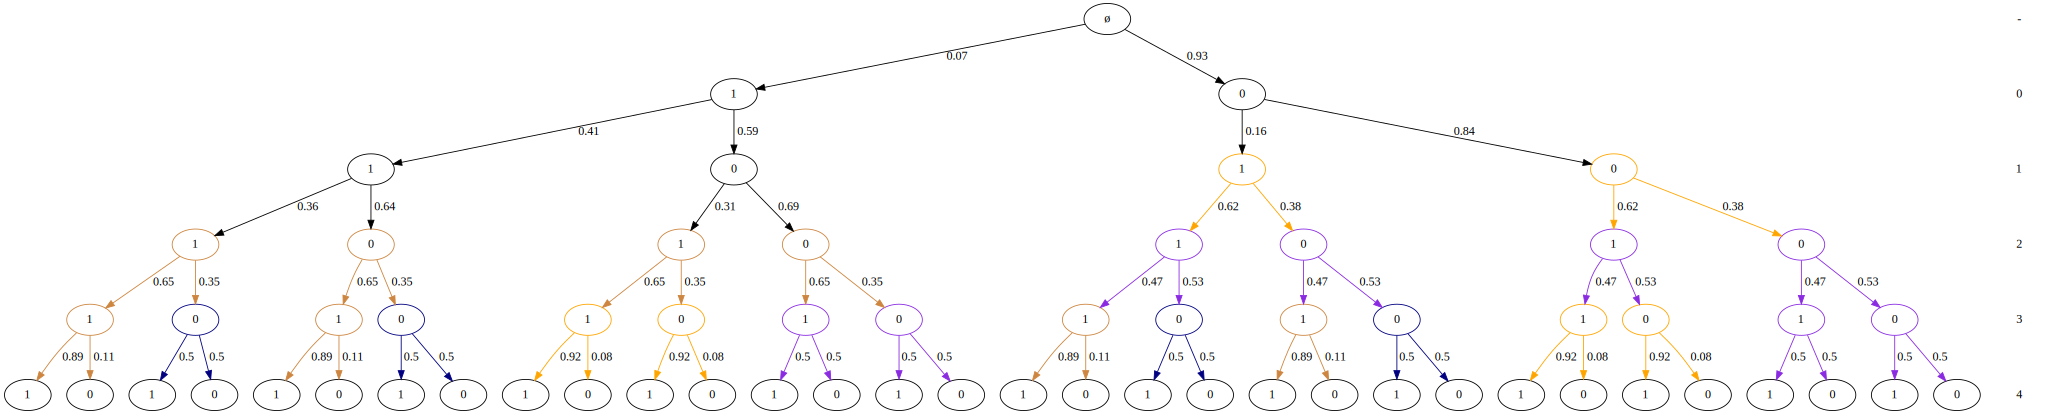

In [51]:
t.plot()

In [52]:
agraphs= t.to_minimal_context_agraphs()
print(len(agraphs))

8


None


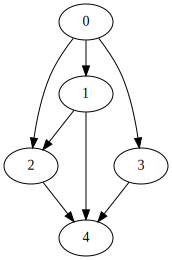

In [53]:
keys = list(agraphs.keys())
print(keys[1])
agraphs[keys[1]]


In [54]:
np.random.seed(6)
x = t.sample(2000)
x

,0,1,2,3,4
0,2,2,2,2,2
1,0,0,0,1,1
2,0,0,1,1,1
3,0,0,1,0,1
4,0,0,1,0,1
...,...,...,...,...,...
1996,0,0,1,0,1
1997,0,1,1,1,1
1998,0,0,0,1,0
1999,0,0,1,0,1


## Create the score tables

In [55]:
t.labels

[0, 1, 2, 3, 4]

In [56]:
poss_cvars = {l:random.sample(list(set(t.labels) - {l}) ,k=3) for l in t.labels}
#poss_cvars = None
poss_cvars

{0: [4, 3, 1], 1: [0, 4, 3], 2: [3, 0, 1], 3: [4, 2, 1], 4: [3, 1, 2]}

In [75]:
score_table, context_scores, context_counts = sc.order_score_tables(x, 
                                                                    max_cvars=1, 
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=poss_cvars)

Context score tables:   0%|          | 0/5 [00:00<?, ?it/s]

Order score tables: 100%|██████████| 5/5 [00:00<00:00, 173.02it/s]



****** var: 0
`staging level`: -1
subset_str: None

staging :  0
stage: []
stage_context: None
staging_marg_lik: -519.0302235861903
staging score:  -520.6396614986245
`staging level`: 0
subset_str: 4

staging :  0
stage: [{0, 1}]
stage_context: None
staging_marg_lik: -519.0302235861903

staging :  1
stage: [0]
stage_context: 4=0
staging_marg_lik: -184.840024738024
stage: [1]
stage_context: 4=1
staging_marg_lik: -517.8244054316415
staging score:  -519.6419082567583
`staging level`: 0
subset_str: 3

staging :  0
stage: [{0, 1}]
stage_context: None
staging_marg_lik: -519.0302235861903

staging :  1
stage: [0]
stage_context: 3=0
staging_marg_lik: -193.8771672090253
stage: [1]
stage_context: 3=1
staging_marg_lik: -512.889172245584
staging score:  -514.9664634416648
`staging level`: 0
subset_str: 1

staging :  0
stage: [{0, 1}]
stage_context: None
staging_marg_lik: -519.0302235861903

staging :  1
stage: [0]
stage_context: 1=0
staging_marg_lik: -333.4111849118439
stage: [1]
stage_context: 

## The order score tables

In [76]:
pp(score_table)

{'max_cvars': 1,
 'poss_cvars': {0: [4, 3, 1],
                1: [0, 4, 3],
                2: [3, 0, 1],
                3: [4, 2, 1],
                4: [3, 1, 2]},
 'scores': {0: {'1': -498.02980471211794,
                '1,3': -498.14758770376255,
                '1,3,4': -498.0298046677898,
                '1,4': -498.1475877474579,
                '3': -514.9664634416648,
                '3,4': -515.0770987406992,
                '4': -519.6419082567583,
                'None': -520.6396614986245},
            1: {'0': -899.5394108283926,
                '0,3': -899.6571938640474,
                '0,3,4': -899.5394108283864,
                '0,4': -899.6571938640448,
                '3': -922.600003415142,
                '3,4': -922.6724055498838,
                '4': -922.5730275789847,
                'None': -922.1492676148993},
            2: {'0': -1348.965962590378,
                '0,1': -1349.0837456260117,
                '0,1,3': -1348.9659625903414,
                

## The context score tables

In [70]:
pp(context_scores)

{'cards': {0: 2, 1: 2, 2: 2, 3: 2, 4: 2},
 'max_cvars': 1,
 'poss_cvars': {0: [4, 3, 1],
                1: [0, 4, 3],
                2: [3, 0, 1],
                3: [4, 2, 1],
                4: [3, 1, 2]},
 'scores': {0: {'1=0': -333.4111849118439,
                '1=1': -162.53917825868893,
                '3=0': -193.8771672090253,
                '3=1': -319.01200503655866,
                '4=0': -184.840024738024,
                '4=1': -332.98438069361754,
                'None': -519.0302235861903},
            1: {'0=0': -796.9845824325496,
                '0=1': -100.47538685425803,
                '3=0': -460.372405950842,
                '3=1': -464.107092833376,
                '4=0': -272.3429120699609,
                '4=1': -651.2475374922356,
                'None': -920.5398297024651},
            2: {'0=0': -1257.1360310151686,
                '0=1': -89.75049003418206,
                '1=0': -1131.3773165101125,
                '1=1': -240.0016791693489,
         

## Run the Gibbs sampler

In [71]:
orders, scores = ctl.gibbs_order_sampler(2000, score_table)

initial order: [2, 4, 0, 3, 1]
node: 2 
subset: None
{'None': -1369.6462828069377, '3': -1370.0955843156028, '0': -1348.965962590378, '1': -1370.0815364495913, '0,3': -1349.083745626021, '1,3': -1370.1793173836356, '0,1': -1349.0837456260117, '0,1,3': -1348.9659625903414}
node: 4 
subset: 2
{'None': -1183.907170333807, '3': -1183.701578916334, '1': -1184.3309302978923, '2': -1042.1851896905077, '1,3': -1183.7955635702726, '2,3': -1042.3029727261644, '1,2': -1042.3029727261644, '1,2,3': -1042.1851896905077}
node: 0 
subset: 4
{'None': -520.6396614986245, '4': -519.6419082567583, '3': -514.9664634416648, '1': -498.02980471211794, '3,4': -515.0770987406992, '1,4': -498.1475877474579, '1,3': -498.14758770376255, '1,3,4': -498.0298046677898}
node: 3 
subset: 2,4
{'None': -1391.8091641845365, '4': -1391.6035727670635, '2': -1392.2584656932015, '1': -1392.2598999847794, '2,4': -1391.7107679074722, '1,4': -1391.7115049141341, '1,2': -1392.3573719816918, '1,2,4': -1391.5832372291788}
node: 1 
s

Gibbs order sampler:   0%|          | 0/2000 [00:00<?, ?it/s]

Gibbs order sampler: 100%|██████████| 2000/2000 [00:00<00:00, 3146.93it/s]


### Trajectory score plots

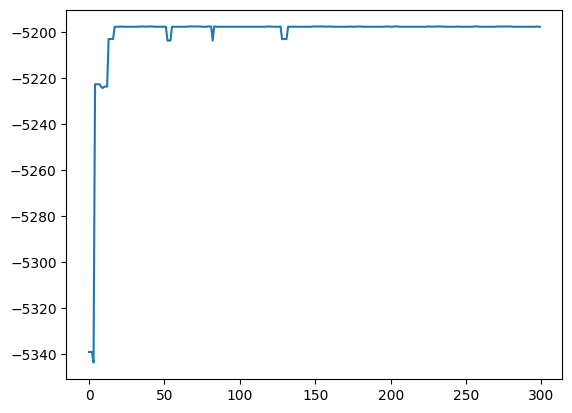

In [61]:
plt.plot(scores[:300])

### Order position plots

Get the individual variables locations in the order and plot them

In [62]:
var_positions = {var: [x.index(var) for x in orders] for var in orders[0]}
var_positions["iteration"] = list(range(len(orders))) 
plotdf = pd.DataFrame(var_positions)

<Axes: xlabel='iteration'>

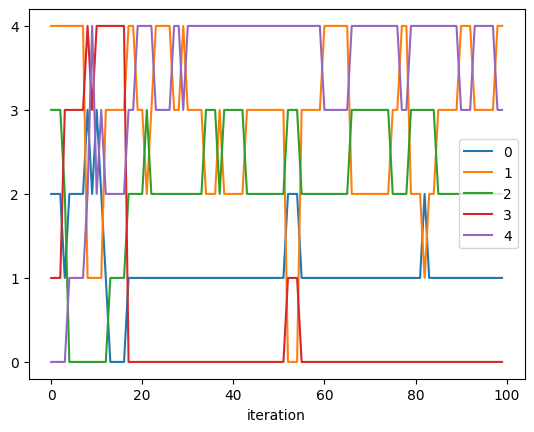

In [63]:
plotdf[:100].plot(x = "iteration", y = range(p), yticks=range(len(orders[0])))

### Get the maximal scoring order

In [64]:
max(scores)
maxi = scores.index(max(scores))
maporder = orders[maxi]
maporder

[3, 0, 1, 2, 4]

### Get the maximal scoring CStree for the order

In [65]:
opttree = ctl._optimal_cstree_given_order(maporder, context_scores)

stage: [{0, 1}]
None
stage: [0]
3=0
stage: [1]
3=1
stage: [{0, 1}, {0, 1}]
None
stage: [0, {0, 1}]
3=0
stage: [1, {0, 1}]
3=1
stage: [{0, 1}, 0]
0=0
stage: [{0, 1}, 1]
0=1
stage: [{0, 1}, {0, 1}, {0, 1}]
None
stage: [0, {0, 1}, {0, 1}]
3=0
stage: [1, {0, 1}, {0, 1}]
3=1
stage: [{0, 1}, 0, {0, 1}]
0=0
stage: [{0, 1}, 1, {0, 1}]
0=1
stage: [{0, 1}, {0, 1}, 0]
1=0
stage: [{0, 1}, {0, 1}, 1]
1=1
stage: [{0, 1}, {0, 1}, {0, 1}, {0, 1}]
None
stage: [0, {0, 1}, {0, 1}, {0, 1}]
3=0
stage: [1, {0, 1}, {0, 1}, {0, 1}]
3=1
stage: [{0, 1}, {0, 1}, 0, {0, 1}]
1=0
stage: [{0, 1}, {0, 1}, 1, {0, 1}]
1=1
stage: [{0, 1}, {0, 1}, {0, 1}, 0]
2=0
stage: [{0, 1}, {0, 1}, {0, 1}, 1]
2=1


## Estimate the CStree parameters

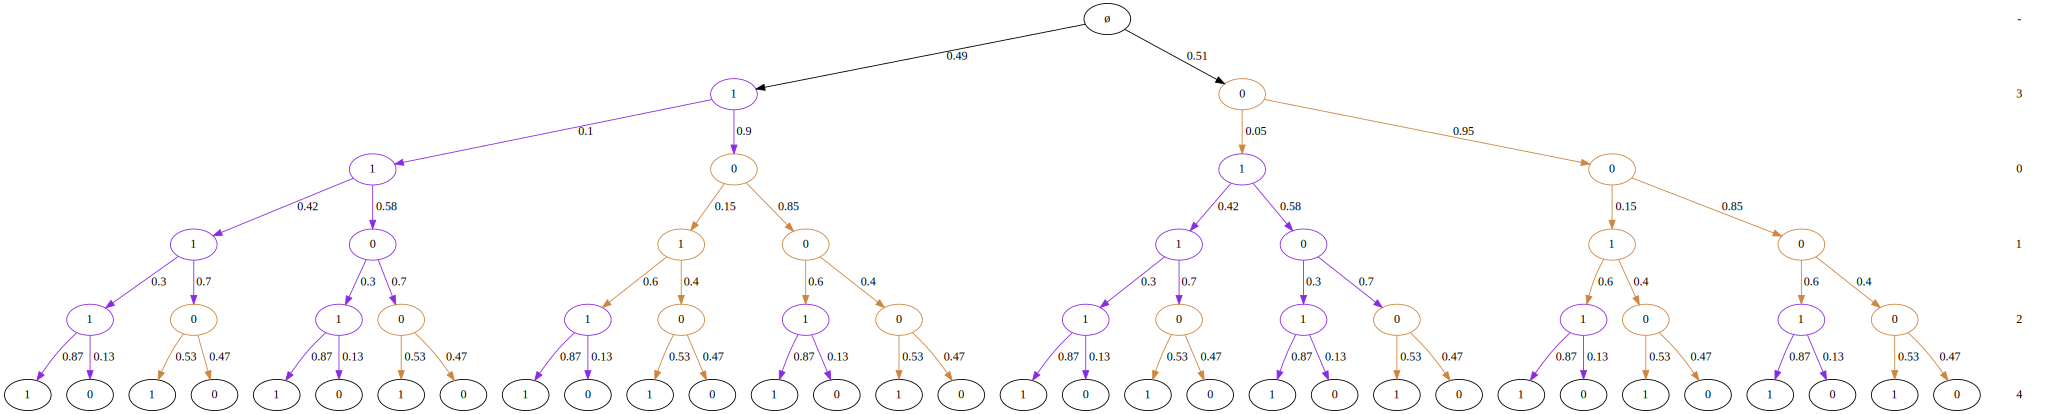

In [66]:
opttree.estimate_stage_parameters(x, alpha_tot=2.0, method="BDeu")
opttree.plot()

## Plot the DAG representation

In [67]:
agraphs= opttree.to_minimal_context_agraphs()
len(agraphs)

1

None


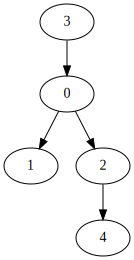

In [68]:
keys = list(agraphs.keys())
print(keys[0])
agraphs[keys[0]]
